In [1]:
# 한글 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

print("한글 폰트 설치 완료!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,775 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126374 files and dire

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 깃허브 개발환경 세팅

In [2]:
# 1. 기존 리포지토리 폴더로 이동
import os
os.chdir('/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project')

In [3]:
# 2. 경로 확인
!pwd

/content/drive/MyDrive/Codeit_AI_4th_Drug_image_CV_project


In [4]:
# 3. 최신 변경사항 가져오기
!git pull origin main

From https://github.com/Dongjin-1203/Codeit_AI_4th_Drug_image_CV_project
 * branch            main       -> FETCH_HEAD
Already up to date.


In [5]:
# 3. 현재 상태 확인
!git status

Refresh index: 100% (6/6), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   notebooks/data_EDA.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


# 코드잇 스프린트 초급 팀 프로젝트: 경구약제 이미지 객체 검출(Object Detection) 프로젝트

이 파일에서는 추후 전처리부터 모델 개발까지 일련의 과정에 핵심이 될 탐색적 데이터 탐색(EDA)를 진행할 예정이다.

## 데이터 탐색 요소
1. 폴더 구조 및 파일 개수 확인
2. JSON annotation 스키마 분석      
3. 이미지 데이터 분석
    - 이미지 해상도, 크기 분포
    - 이미지 품질 검사(손상된 파일, 노이즈 등)
    - 색상 분포 및 밝기 분석
    - 알약 형태별 분포
4. 라벨 데이터 분석
    - 클래스 분포 및 불균형 확인
    - 알약 종류별 통계
    - 제약회사별, 성분별 분포(판단 필요)
    - Missing value 및 이상치 탐지

한번에 실행하지 않고 단계별로 진행할 예정

## 1. 초기 세팅

In [6]:
import os
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

In [7]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. 폴더 구조 및 파일 개수 분석

### 폴더 구조 및 파일 개수 확인

In [8]:
def check_dataset_structure(data_path):
    """데이터셋 기본 구조 확인"""
    data_path = Path(data_path)

    print("="*60)
    print("📁 데이터셋 구조 분석")
    print("="*60)

    if not data_path.exists():
        print(f"❌ 경로 없음: {data_path}")
        return {}

    results = {}

    # Train 이미지 확인
    train_img_path = data_path / "train_images"
    if train_img_path.exists():
        train_images = list(train_img_path.glob("*.png"))
        results['train_images'] = len(train_images)
        print(f"✅ Train 이미지: {len(train_images):,}개")

        # 파일명 패턴 분석
        if train_images:
            sample_names = [f.stem for f in train_images[:5]]
            print(f"📝 Train 파일명 샘플:")
            for name in sample_names:
                print(f"   {name}")
    else:
        results['train_images'] = 0
        print("❌ train_images 폴더 없음")

    # Test 이미지 확인
    test_img_path = data_path / "test_images"
    if test_img_path.exists():
        test_images = list(test_img_path.glob("*.png"))
        results['test_images'] = len(test_images)
        print(f"✅ Test 이미지: {len(test_images):,}개")
    else:
        results['test_images'] = 0
        print("❌ test_images 폴더 없음")

    # Annotation 폴더 구조 확인
    train_ann_path = data_path / "train_annotations"
    if train_ann_path.exists():
        print(f"✅ Train annotations 폴더 존재")

        # 하위 폴더 구조 탐색
        all_json_files = list(train_ann_path.glob("**/*.json"))
        results['train_annotations'] = len(all_json_files)
        print(f"📝 총 JSON 파일: {len(all_json_files):,}개")

        # 폴더 구조 분석
        subfolders = [d for d in train_ann_path.iterdir() if d.is_dir()]
        print(f"📂 Annotation 하위 폴더: {len(subfolders)}개")

        for subfolder in subfolders[:3]:  # 처음 3개만
            sub_subfolders = [d for d in subfolder.iterdir() if d.is_dir()]
            json_count = len(list(subfolder.glob("**/*.json")))
            print(f"   📁 {subfolder.name}/ ({len(sub_subfolders)}개 하위폴더, {json_count}개 JSON)")

        if len(subfolders) > 3:
            print(f"   ... 외 {len(subfolders)-3}개 폴더")

    else:
        results['train_annotations'] = 0
        print("❌ train_annotations 폴더 없음")

    return results

### 이미지 해상도, 채널, 용량 등 속성 분석

In [9]:
def analyze_image_properties(data_path, sample_size=10):
    """이미지 해상도, 채널, 용량 등 속성 분석"""
    # TODO: train_images와 test_images 폴더에서 샘플 이미지들을 읽어서
    # - 해상도 분포 (width, height)
    # - 채널 수 (RGB, RGBA 등)
    # - 파일 크기 분포
    # - 이미지 모드 확인
    # PIL.Image.open()을 사용해서 구현하세요
    data_path = Path(data_path)

    def find_image_size(image_path):
        try:
            # 이미지 열기
            image = Image.open(image_path)
            # 이미지 크기(해상도) 반환
            width, height = image.size
            return width, height
        except FileNotFoundError:
            print("이미지 파일을 찾을 수 없습니다.")
        except Exception as e:
            print("오류 발생:", e)

    train_img_path = data_path / "train_images"
    # 너비, 높이 리스트 생성
    train_width_list = []
    train_height_list = []

    # train 이미지 속성 분석
    if train_img_path.exists():
        train_files = list(train_img_path.glob("*.png"))
        # print(train_files)
        for train_file in train_files:

            # 너비, 높이 계산
            train_width, train_height = find_image_size(train_file)

            # 너비, 높이 데이터 저장
            train_width_list.append(train_width)
            train_height_list.append(train_height)

        # 시각화
        plt.figure(figsize=(10, 8))
        plt.scatter(train_width_list, train_height_list, alpha=0.6, s=20)
        plt.xlabel('Width (px)')
        plt.ylabel('Height (px)')
        plt.title('train 이미지 해상도 분포')

        # 대각선 그어서 정사각형 영역 표시
        max_size = max(max(train_width_list), max(train_height_list))
        plt.plot([0, max_size], [0, max_size], 'r--', alpha=0.5, label='정사각형')
        plt.legend()
        plt.show()

    test_img_path = data_path / "test_images"
    # 너비, 높이 리스트 생성
    test_width_list = []
    test_height_list = []

    # test 이미지 속성 분석
    if test_img_path.exists():
        test_files = list(test_img_path.glob("*.png"))

        for test_file in test_files:
            # 너비, 높이 계산
            test_width, test_height = find_image_size(test_file)

            # 너비, 높이 데이터 저장
            test_width_list.append(test_width)
            test_height_list.append(test_height)

        # 시각화
        plt.figure(figsize=(10, 8))
        plt.scatter(test_width_list, test_height_list, alpha=0.6, s=20)
        plt.xlabel('Width (px)')
        plt.ylabel('Height (px)')
        plt.title('test 이미지 해상도 분포')

        # 대각선 그어서 정사각형 영역 표시
        max_size = max(max(test_width_list), max(test_height_list))
        plt.plot([0, max_size], [0, max_size], 'r--', alpha=0.5, label='정사각형')
        plt.legend()
        plt.show()

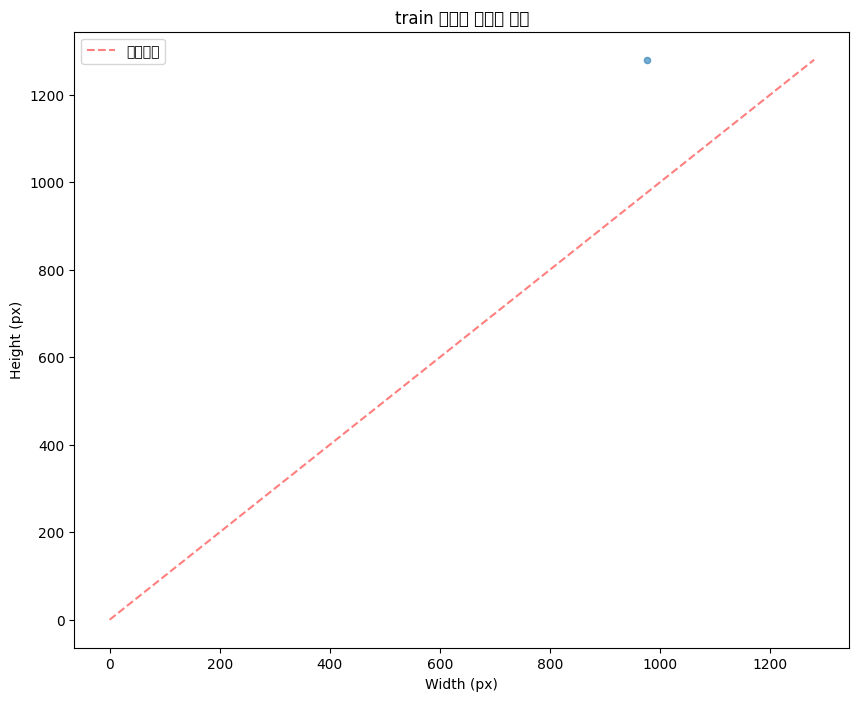

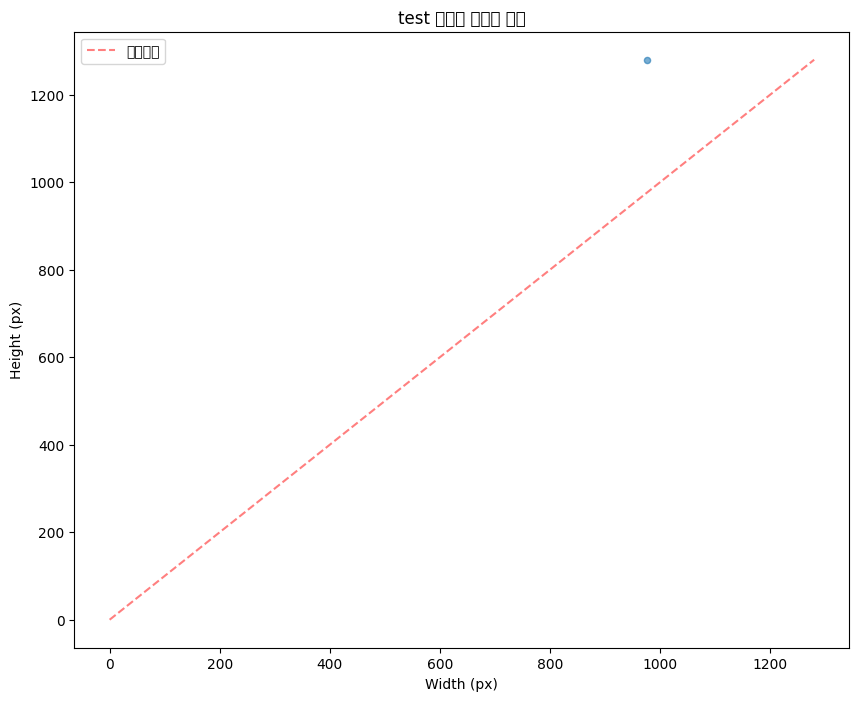

In [59]:
data_path = "data/"
analyze_image_properties(data_path)

### Annotation 기본 정보 확인

In [10]:
def check_annotation_sample(data_path, sample_count=3):
    """샘플 annotation JSON 파일 구조 확인"""
    train_ann_path = Path(data_path) / "train_annotations"

    print("\n" + "="*60)
    print(f"📝 Annotation JSON 샘플 분석 ({sample_count}개)")
    print("="*60)

    if not train_ann_path.exists():
        print("❌ train_annotations 폴더 없음")
        return None

    # JSON 파일들 찾기
    json_files = list(train_ann_path.glob("**/*.json"))[:sample_count]

    if not json_files:
        print("❌ JSON 파일 없음")
        return None

    sample_data = []

    for i, json_file in enumerate(json_files, 1):
        print(f"\n🔍 샘플 {i}: {json_file.name}")
        print(f"   경로: {json_file.relative_to(train_ann_path)}")

        try:
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)

            print(f"   📊 JSON 구조:")
            print(f"      타입: {type(data)}")

            if isinstance(data, dict):
                print(f"      키들: {list(data.keys())}")

                # 각 키의 내용 간단히 확인
                for key, value in data.items():
                    if isinstance(value, list):
                        print(f"         {key}: 리스트 ({len(value)}개)")
                        if value and isinstance(value[0], dict):
                            print(f"            첫 요소 키: {list(value[0].keys())}")
                    elif isinstance(value, dict):
                        print(f"         {key}: 딕셔너리 ({len(value)}개 키)")
                        print(f"            키들: {list(value.keys())}")
                    else:
                        print(f"         {key}: {type(value).__name__} = {value}")

            elif isinstance(data, list):
                print(f"      리스트 길이: {len(data)}")
                if data and isinstance(data[0], dict):
                    print(f"      첫 요소 키: {list(data[0].keys())}")

            sample_data.append(data)

        except Exception as e:
            print(f"   ❌ JSON 읽기 오류: {e}")

    return sample_data

### 이미지와 annotation 파일 매칭 확인

In [11]:
def check_file_matching(data_path):
    """이미지와 annotation 파일 매칭 확인"""
    data_path = Path(data_path)
    train_img_path = data_path / "train_images"
    train_ann_path = data_path / "train_annotations"

    print("\n" + "="*60)
    print("🔗 이미지-Annotation 매칭 확인")
    print("="*60)

    if not train_img_path.exists() or not train_ann_path.exists():
        print("❌ 필요한 폴더가 없습니다")
        return

    # 이미지 파일명들
    image_files = list(train_img_path.glob("*.png"))
    image_names = {f.stem for f in image_files}

    # JSON 파일명들
    json_files = list(train_ann_path.glob("**/*.json"))
    json_names = {f.stem for f in json_files}

    print(f"🖼️  이미지 파일: {len(image_names):,}개")
    print(f"📝 JSON 파일: {len(json_names):,}개")

    # 매칭 확인
    matched = image_names.intersection(json_names)
    image_only = image_names - json_names
    json_only = json_names - image_names

    print(f"✅ 매칭됨: {len(matched):,}개")
    print(f"🖼️  이미지만 있음: {len(image_only):,}개")
    print(f"📝 JSON만 있음: {len(json_only):,}개")

    # 매칭 안된 파일들 샘플 출력
    if image_only:
        print(f"\n📝 이미지만 있는 파일 샘플:")
        for name in list(image_only)[:5]:
            print(f"   {name}")
        if len(image_only) > 5:
            print(f"   ... 외 {len(image_only)-5}개")

    if json_only:
        print(f"\n📝 JSON만 있는 파일 샘플:")
        for name in list(json_only)[:5]:
            print(f"   {name}")
        if len(json_only) > 5:
            print(f"   ... 외 {len(json_only)-5}개")

    return {
        'matched': len(matched),
        'image_only': len(image_only),
        'json_only': len(json_only),
        'match_rate': len(matched) / max(len(image_names), 1) * 100
    }

### Annotation 폴더 패턴 분석

In [12]:
def analyze_folder_patterns(data_path):
    """Annotation 폴더 패턴 분석"""
    train_ann_path = Path(data_path) / "train_annotations"

    print("\n" + "="*60)
    print("📂 Annotation 폴더 패턴 분석")
    print("="*60)

    if not train_ann_path.exists():
        print("❌ train_annotations 폴더 없음")
        return

    # 첫 번째 레벨 폴더들
    first_level = [d for d in train_ann_path.iterdir() if d.is_dir()]
    print(f"📁 1단계 폴더: {len(first_level)}개")

    for folder in first_level[:3]:
        print(f"\n🔍 {folder.name}/")

        # 두 번째 레벨 폴더들
        second_level = [d for d in folder.iterdir() if d.is_dir()]
        json_files = list(folder.glob("**/*.json"))

        print(f"   📁 하위 폴더: {len(second_level)}개")
        print(f"   📝 JSON 파일: {len(json_files)}개")

        # 폴더명 패턴 분석
        if second_level:
            folder_names = [d.name for d in second_level[:5]]
            print(f"   📋 하위 폴더명 샘플: {folder_names}")

            # 각 하위 폴더의 JSON 개수
            for sub_folder in second_level[:3]:
                sub_json = len(list(sub_folder.glob("*.json")))
                print(f"      {sub_folder.name}: {sub_json}개 JSON")

### 실행

In [13]:
def quick_dataset_analysis(data_path):
    """전체 데이터셋 빠른 분석"""
    print("🚀 경구알약 데이터셋 분석 시작")
    print(f"📂 분석 경로: {data_path}")

    # 1. 기본 구조 확인
    structure_results = check_dataset_structure(data_path)

    # 2. 이미지 해상도, 채널, 용량 등 속성 분석
    image_properties = analyze_image_properties(data_path)

    # 3. 샘플 annotation 확인
    sample_data = check_annotation_sample(data_path)

    # 4. 파일 매칭 확인
    matching_results = check_file_matching(data_path)

    # 5. 폴더 패턴 분석
    analyze_folder_patterns(data_path)

    print("\n" + "="*60)
    print("📊 분석 요약")
    print("="*60)
    print(f"✅ Train 이미지: {structure_results.get('train_images', 0):,}개")
    print(f"✅ Test 이미지: {structure_results.get('test_images', 0):,}개")
    print(f"✅ Train annotations: {structure_results.get('train_annotations', 0):,}개")

    if matching_results:
        print(f"🔗 매칭률: {matching_results['match_rate']:.1f}%")

    print("\n✅ 분석 완료!")

    return structure_results, image_properties, sample_data, matching_results

💡 사용법:
1. DATA_PATH 변수를 실제 경로로 수정
2. quick_analysis('경로') 직접 실행
🚀 경구알약 데이터셋 분석 시작
📂 분석 경로: data/
📁 데이터셋 구조 분석
✅ Train 이미지: 1,489개
📝 Train 파일명 샘플:
   K-003351-013900-036637_0_2_0_2_70_000_200
   K-003351-016232-018147_0_2_0_2_75_000_200
   K-003351-016232-019232_0_2_0_2_70_000_200
   K-003351-013900-035206_0_2_0_2_70_000_200
   K-003351-013900-035206_0_2_0_2_90_000_200
✅ Test 이미지: 843개
✅ Train annotations 폴더 존재
📝 총 JSON 파일: 4,526개
📂 Annotation 하위 폴더: 498개
   📁 K-001900-016548-018110-021026_json/ (4개 하위폴더, 10개 JSON)
   📁 K-001900-016548-018110-029451_json/ (4개 하위폴더, 10개 JSON)
   📁 K-001900-016548-018110-031705_json/ (4개 하위폴더, 11개 JSON)
   ... 외 495개 폴더


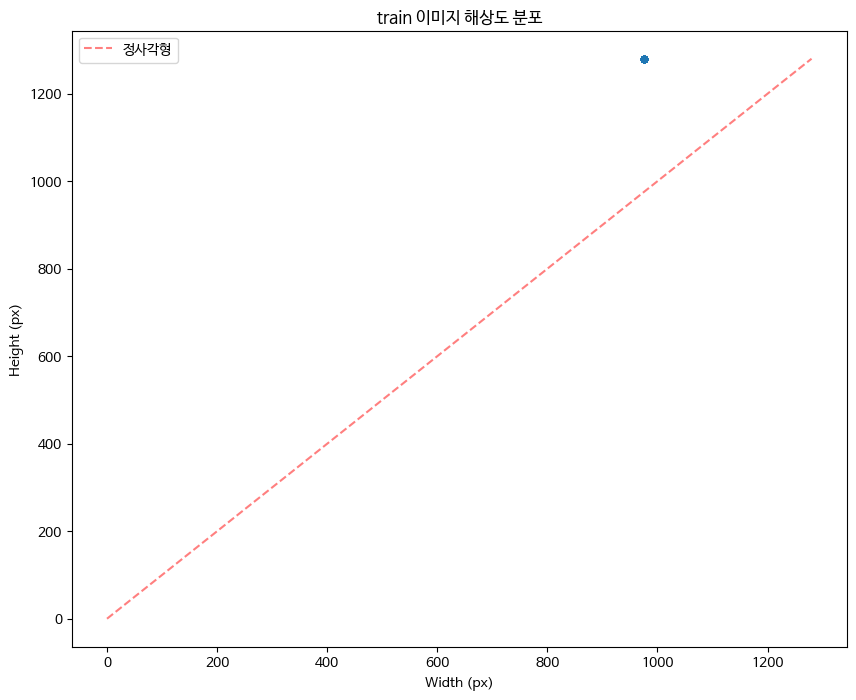

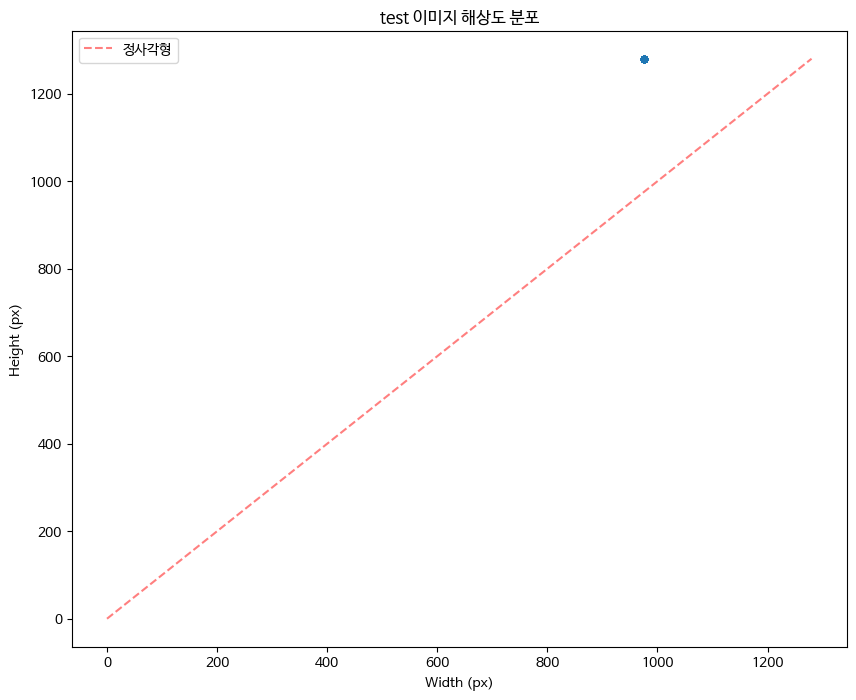


📝 Annotation JSON 샘플 분석 (3개)

🔍 샘플 1: K-001900-016548-018110-021026_0_2_0_2_75_000_200.json
   경로: K-001900-016548-018110-021026_json/K-001900/K-001900-016548-018110-021026_0_2_0_2_75_000_200.json
   📊 JSON 구조:
      타입: <class 'dict'>
      키들: ['images', 'type', 'annotations', 'categories']
         images: 리스트 (1개)
            첫 요소 키: ['file_name', 'width', 'height', 'imgfile', 'drug_N', 'drug_S', 'back_color', 'drug_dir', 'light_color', 'camera_la', 'camera_lo', 'size', 'dl_idx', 'dl_mapping_code', 'dl_name', 'dl_name_en', 'img_key', 'dl_material', 'dl_material_en', 'dl_custom_shape', 'dl_company', 'dl_company_en', 'di_company_mf', 'di_company_mf_en', 'item_seq', 'di_item_permit_date', 'di_class_no', 'di_etc_otc_code', 'di_edi_code', 'chart', 'drug_shape', 'thick', 'leng_long', 'leng_short', 'print_front', 'print_back', 'color_class1', 'color_class2', 'line_front', 'line_back', 'img_regist_ts', 'form_code_name', 'mark_code_front_anal', 'mark_code_back_anal', 'mark_code_front_img',

In [14]:
# 실행
if __name__ == "__main__":
    print("💡 사용법:")
    print("1. DATA_PATH 변수를 실제 경로로 수정")
    print("2. quick_analysis('경로') 직접 실행")

    # 경로 직접 지정해서 실행
    data_path = "data/"
    results = quick_dataset_analysis(data_path)

## 깃허브 업로드용 코드

In [40]:
# 전역 설정 (권장) - 이 Colab 세션에서 계속 사용
!git config --global user.name "Dongjin-1203"
!git config --global user.email "hambur1203@gmail.com"

In [41]:
!git add .

In [42]:
!git commit -m "EDA 폴더 구조 및 파일 개수 분석 MVP 작성"

[main 8190e39] EDA 폴더 구조 및 파일 개수 분석 MVP 작성
 2 files changed, 2 insertions(+), 1 deletion(-)
 create mode 100644 notebooks/data_EDA.ipynb


In [43]:
!git pull origin main

From https://github.com/Dongjin-1203/Codeit_AI_4th_Drug_image_CV_project
 * branch            main       -> FETCH_HEAD
Already up to date.


In [44]:
!git push origin main

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 7.85 KiB | 502.00 KiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Dongjin-1203/Codeit_AI_4th_Drug_image_CV_project.git
   e0c35de..8190e39  main -> main
